[View in Colaboratory](https://colab.research.google.com/github/yylonly/GoogleCoLab/blob/master/4_ServeNet_LTSM_(Glove50b_trainedEmbeddingLayer).ipynb)

## ServeNet-LTSM (Glove50b-trainedEmbeddingLayer)

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("/content/drive/Colab Notebooks/")

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [3]:
!ls a

10.TensorFlow				      Copy of Hello, Colaboratory
14.Residual Networks			      data
15.CarDetectionwithYOLOv2		      datasets
16.Neural Style Transfer		      env.ipynb
17.Face Recognition			      images
1.Python Basics with Numpy		      ORGANIC.ipynb
2.Logistic Regression as a Neural Network     pix2pix.ipynb
CalligraphyColorNet.ipynb		      ServeNet
CalligraphyNet.ipynb			      SQCalligraphyNet.ipynb
Copy of CalligraphyColorNet (019b6ded).ipynb  tensorflowtest.ipynb
Copy of CalligraphyColorNet.ipynb


In [0]:
#import plaidml.keras
#plaidml.keras.install_backend()

import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import csv
import h5py

#from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model
from keras import metrics
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint

np.random.seed(0)
%matplotlib inline

In [5]:
h5f = h5py.File('data/SplittedPaddedIndexedServiceDataset.h5','r') 
X_train = h5f['indexed_padded_Train_X'][:]
Y_train = h5f['Train_Y_one_hot'][:]
X_test = h5f['indexed_padded_Test_X'][:]
Y_test = h5f['Test_Y_one_hot'][:]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8123, 110) (8123, 50)
(2061, 110) (2061, 50)


In [6]:
X_train[0]

array([192973,  54273, 270501, 294803, 286278, 121851, 360915, 363921,
       270193, 219115, 154323, 278439, 291761, 191811, 191143, 270193,
       133719, 142813, 388756, 306178, 104329, 142808, 374253, 357266,
       286278, 354433,  54718, 345909, 236860, 142838,  90548, 327482,
       357354, 209662, 374253,  43010, 111455,  91182, 156214,  58791,
       270501,  57488,  54718, 149979, 136170, 270927, 294049,  43010,
       332120, 186717,  69725,  57459, 151349,  86371, 191143, 219115,
        57840, 386474,  58997,  89857, 156216, 122453, 374163, 182908,
       199199, 113067, 360915, 111448, 156216, 386474,  58997, 357412,
       182158, 269798, 357266, 286278,  54718, 107110,  88126, 354433,
       151349, 219113, 360915, 191135, 388711, 357266, 325899, 268046,
       325776, 188836, 281890,  61645, 373469, 363840,  54718,  61640,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0], dtype=int32)

In [7]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def trainable_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
# GRADED FUNCTION: Emojify_V2

def ServeNet(input_shape):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trainable_embedding_layer()
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) 
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(256, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(256, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(50)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

Run the following cell to create your model and check its summary. Because all sentences in the dataset are less than 10 words, we chose `max_len = 10`.  You should see your architecture, it uses "20,223,927" parameters, of which 20,000,050 (the word embeddings) are non-trainable, and the remaining 223,877 are. Because our vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters. 

In [0]:
maxLen = 110

In [14]:
model = ServeNet((maxLen, ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 110)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 110, 50)           20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 110, 256)          314368    
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 256)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12850     
__________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy, metrics.top_k_categorical_accuracy])

In [0]:
filepath = "glove50-checkpoints.hdf5"

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(filepath, monitor='acc')

In [66]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 100, batch_size = 128, callbacks=[checkpoint])

Train on 8123 samples, validate on 2061 samples
Epoch 1/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2339 - categorical_accuracy: 0.9356 - top_k_categorical_accuracy: 0.9932 - val_loss: 2.8711 - val_categorical_accuracy: 0.5420 - val_top_k_categorical_accuracy: 0.7661
Epoch 2/100
8123/8123 [==============================] - 38s 5ms/step - loss: 0.2218 - categorical_accuracy: 0.9380 - top_k_categorical_accuracy: 0.9948 - val_loss: 2.8120 - val_categorical_accuracy: 0.5536 - val_top_k_categorical_accuracy: 0.7758
Epoch 3/100
8123/8123 [==============================] - 37s 5ms/step - loss: 0.1936 - categorical_accuracy: 0.9460 - top_k_categorical_accuracy: 0.9962 - val_loss: 2.7753 - val_categorical_accuracy: 0.5483 - val_top_k_categorical_accuracy: 0.7768
Epoch 4/100
1664/8123 [=====>........................] - ETA: 28s - loss: 0.1811 - categorical_accuracy: 0.9435 - top_k_categorical_accuracy: 0.9988

8123/8123 [==============================] - 43s 5ms/step - loss: 0.1668 - categorical_accuracy: 0.9549 - top_k_categorical_accuracy: 0.9958 - val_loss: 2.9702 - val_categorical_accuracy: 0.5449 - val_top_k_categorical_accuracy: 0.7826
Epoch 5/100
8123/8123 [==============================] - 43s 5ms/step - loss: 0.1617 - categorical_accuracy: 0.9554 - top_k_categorical_accuracy: 0.9975 - val_loss: 2.9431 - val_categorical_accuracy: 0.5415 - val_top_k_categorical_accuracy: 0.7792
Epoch 6/100
8123/8123 [==============================] - 37s 5ms/step - loss: 0.2139 - categorical_accuracy: 0.9399 - top_k_categorical_accuracy: 0.9956 - val_loss: 2.8493 - val_categorical_accuracy: 0.5492 - val_top_k_categorical_accuracy: 0.7821


KeyboardInterrupt: ignored

In [43]:
!ls -l

total 97752
drwxr-xr-x 2 root root     4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root     4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root     4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root     4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root     4096 Mar  1 18:00 17.Face Recognition
drwxr-xr-x 2 root root     4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root     4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root    48080 Mar 29 16:22 CalligraphyColorNet.ipynb
-rw-r--r-- 1 root root  1377049 Mar 19 08:13 CalligraphyNet.ipynb
-rw-r--r-- 1 root root   969393 Mar 31 08:46 Copy of CalligraphyColorNet (019b6ded).ipynb
-rw-r--r-- 1 root root   969393 Apr  3 08:48 Copy of CalligraphyColorNet.ipynb
-rw-r--r-- 1 root root    39658 Mar 16 23:44 Copy of Hello, Colaboratory
drwxr-xr-x 2 root root     4096 May  4 13:16 data
drwxr-xr-x 2 root root     4096 Mar 29 13:53 datasets
-rw-r--r-- 1 ro

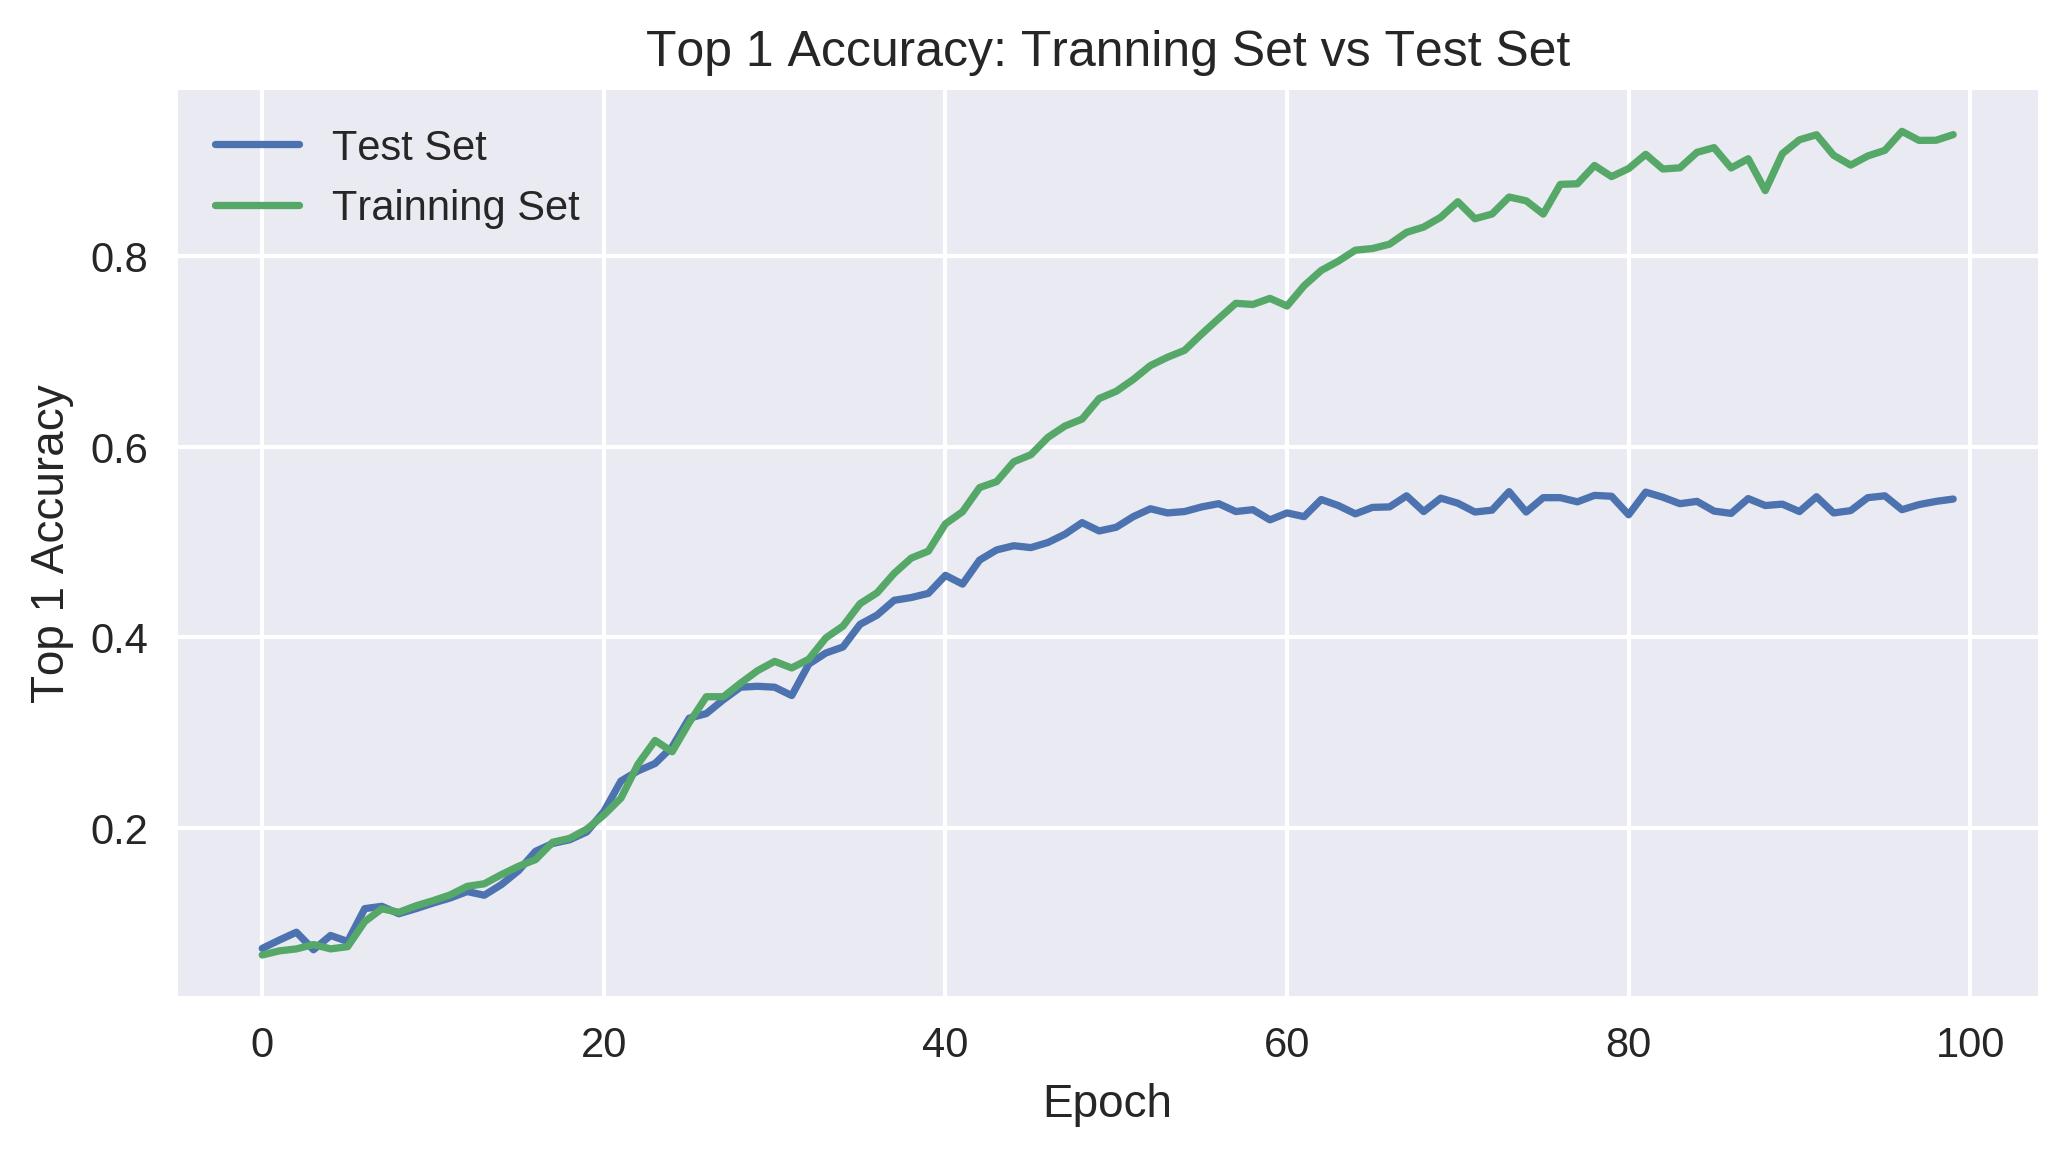

In [56]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig('glove50-top5.pdf', format='pdf', dpi=300)

### Plot Loss

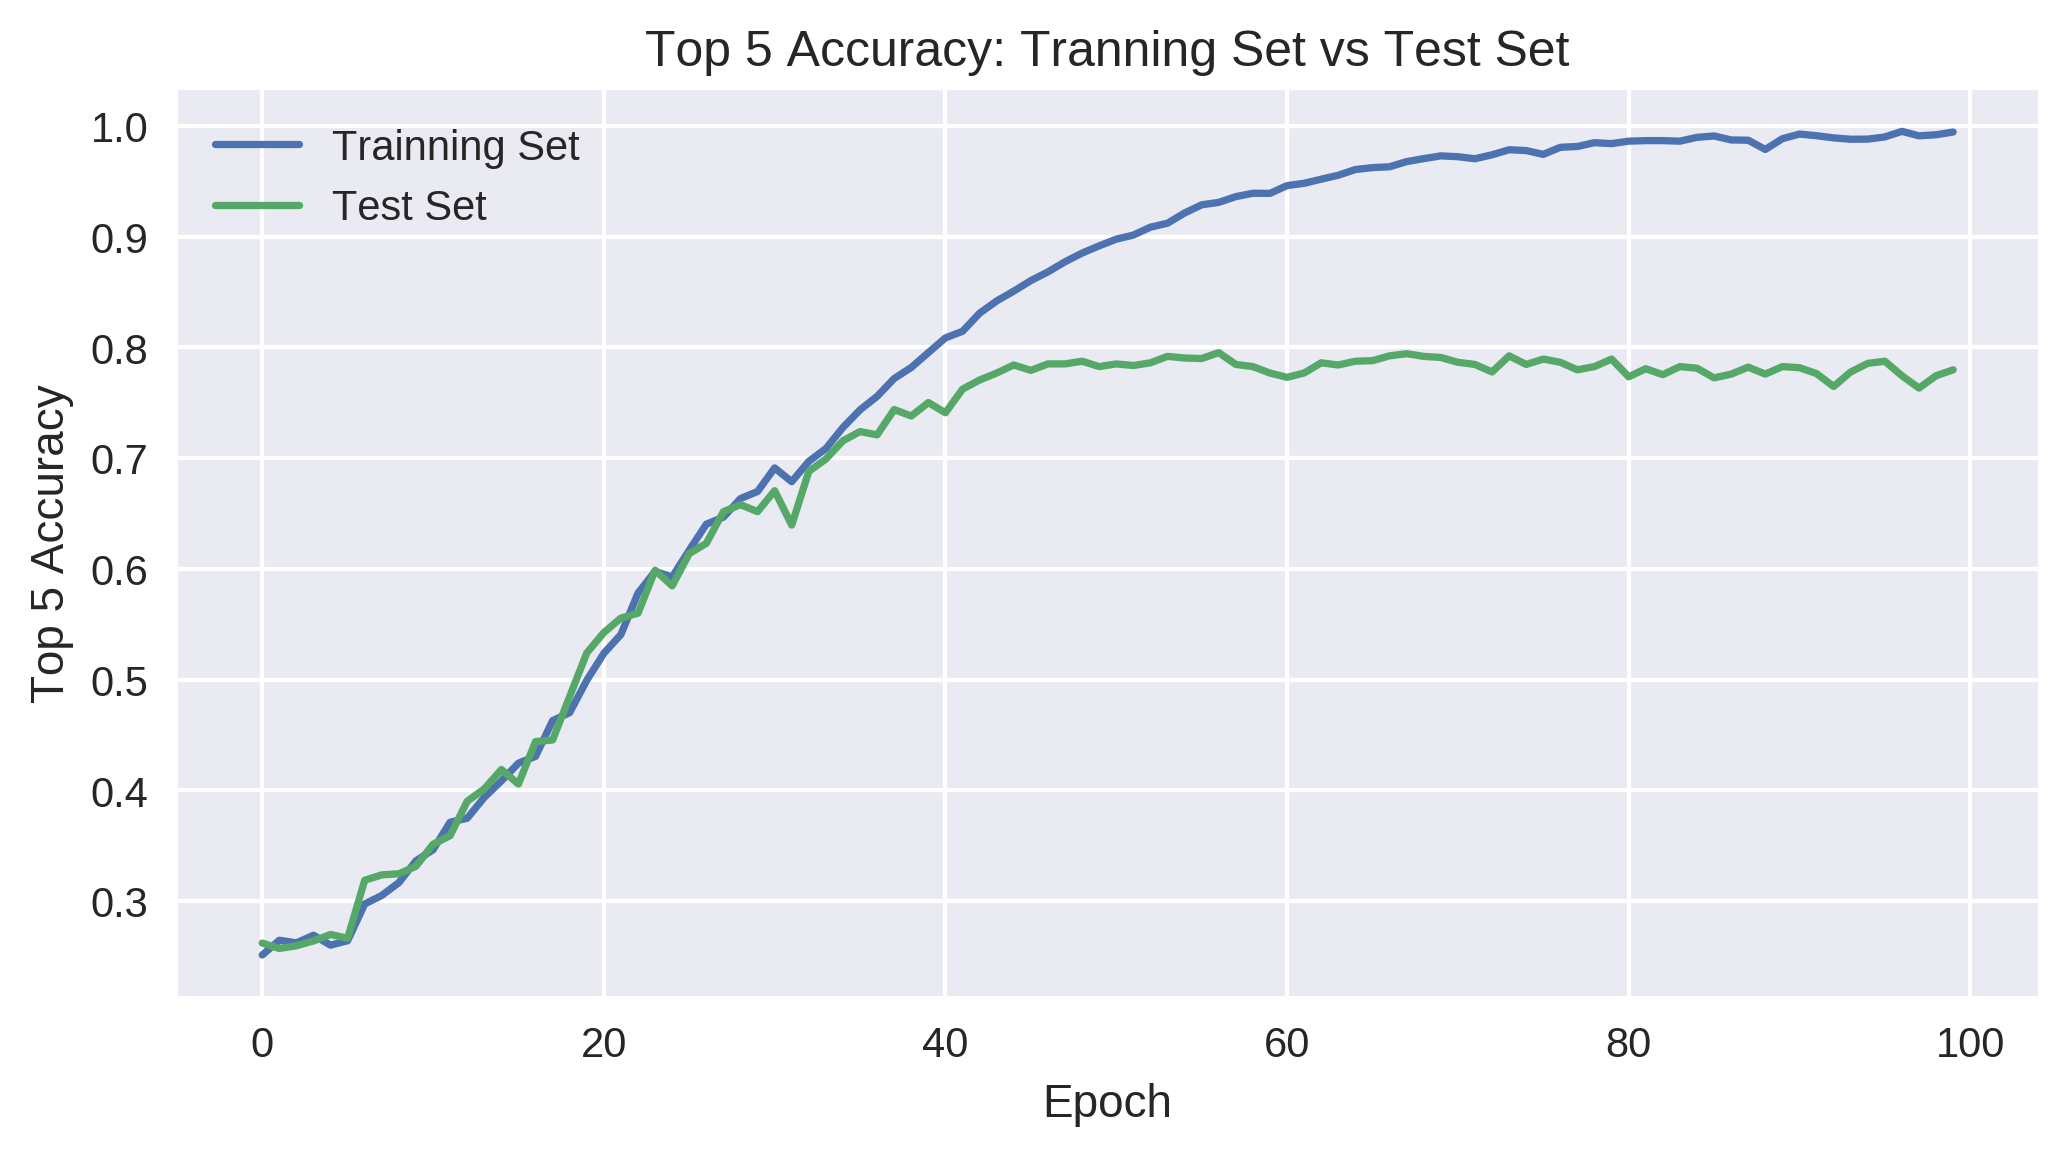

In [58]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()
plt.savefig('glove50-top5.pdf', format='pdf', dpi=300)

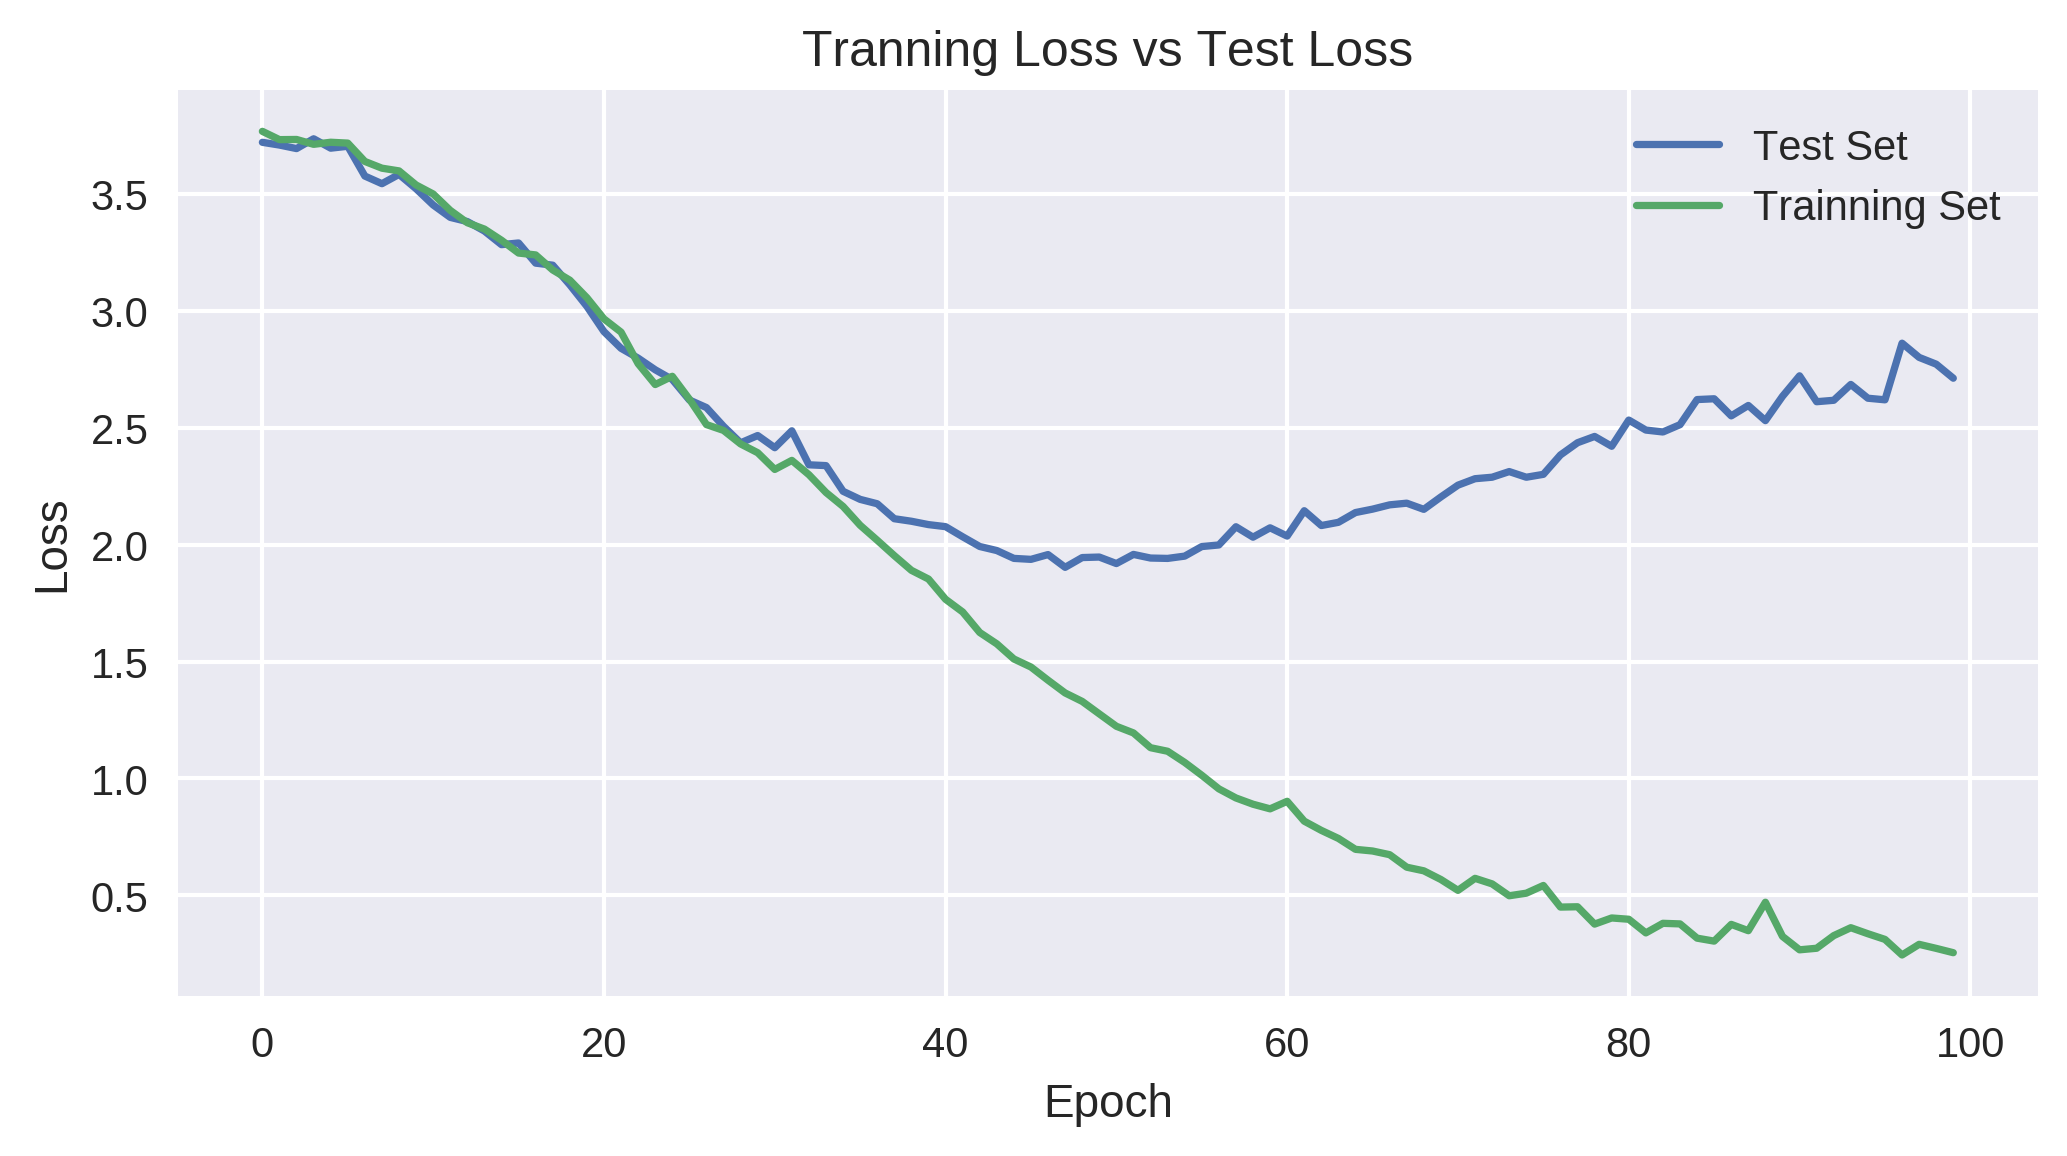

In [57]:
# plot metrics

plt.figure(figsize=(8, 4), dpi=300)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig('glove50-loss.pdf', format='pdf', dpi=300)

### Model Save

In [0]:
model.save('Serve_Net_Glove50.h5') 

### Model Load

In [0]:
model = load_model('Serve_Net_Glove50.h5')

In [45]:
print("Training set:")
loss_train, mae_train, top5error_train = model.evaluate(X_train, Y_train)
print("Training accuracy = ", top5error_train)
print('Test set:')
loss_test, mae_test, top5error_test = model.evaluate(X_test, Y_test)
print("Training accuracy = ", top5error_test)

Training set:
8123/8123 [==============================] - 33s 4ms/step
Training accuracy =  0.9981533916040871
Test set:
2061/2061 [==============================] - 8s 4ms/step
Training accuracy =  0.7797185833566342


In [61]:
import keras; print(keras.__version__)

2.1.6


In [46]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

NameError: ignored

You should get a test accuracy between 80% and 95%. Run the cell below to see the mislabelled examples. 

In [47]:
# This code allows you to see the mislabelled examples
C = 50
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

IndexError: ignored

Now you can try it on your own example. Write your own sentence below. 

In [0]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['not feeling happy'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

Previously, Emojify-V1 model did not correctly label "not feeling happy," but our implementation of Emojiy-V2 got it right. (Keras' outputs are slightly random each time, so you may not have obtained the same result.) The current model still isn't very robust at understanding negation (like "not happy") because the training set is small and so doesn't have a lot of examples of negation. But if the training set were larger, the LSTM model would be much better than the Emojify-V1 model at understanding such complex sentences. 


In [49]:
import pandas as pd

print(Y_test.shape)
# print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
cross = pd.crosstab(Y_test, pred_test.reshape(len(pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)

f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()

ax.xaxis.set_label_position('top')

# ax.yaxis.set_label_position('right')

ax.set_xticklabels(list(index_to_category.values()), minor=False, rotation=90)
ax.set_yticklabels(list(index_to_category.values()), minor=False, rotation=90)

plt.yticks(rotation=0) 

plt.savefig('heatmap.pdf', format='pdf', dpi=300)

# plot_confusion_matrix(Y_test, pred_test)

(2061, 50)


NameError: ignored